In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import math
import seaborn as sns
import os
from adjustText import adjust_text

In [3]:
from scipy import stats
from statsmodels.stats import multitest
def test_sig(x, y):
    if stats.shapiro(x).pvalue >= 0.05 and stats.shapiro(y).pvalue >= 0.05: #if they are normally distriuted
        print("t-test")
        return stats.ttest_ind(x,y)
    else:
        print("mann-whitney")
        return stats.mannwhitneyu(x, y)
def test_mannwhit(x, y):
    return stats.mannwhitneyu(x, y)
def test_ttest(x, y):
    return stats.ttest_ind(x, y)
def test_fdr(x):
     return multitest.fdrcorrection(x, alpha=0.05, method='indep', is_sorted=False)

In [4]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"    
    elif pvalue <= 0.05:
        return "*"
    return ""

def convert_FDR_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "*****"
    elif pvalue <= 0.001:
        return "****"
    elif pvalue <= 0.01:
        return "***"
    elif pvalue <= 0.05:
        return "**"    
    elif pvalue <= 0.1:
        return "*"
    return ""

In [5]:
# Read antibody file
data = pd.read_excel('antibody_data.xlsx')

In [6]:
visits = ['Day0','Day 25','Day 35','Day 70']
vaccine_n= ['J&J','Moderna','PFIZER']
tot=[]
for i in visits:
    for k in vaccine_n:
        data_temp = data[data['VACCINE'] == k].copy()
        if not data_temp[i].isna().all():
            data_temp['age'] = data_temp['AGE (yrs)']
            data_temp['gender'] = data_temp['GENDER']
            data_temp['donor'] = data_temp['SUBJECT ID']
            data_temp['SUBJECT ID'] = data_temp['SUBJECT ID'].astype(str) + '_' + i 
            data_temp = data_temp.rename(columns={i:'titer'})
            data_temp['Visit'] = i
            tot.append(data_temp[['SUBJECT ID','VACCINE','titer','Visit','donor','age','gender']])

In [8]:
final = pd.concat(tot,axis=0)
final['titer_0.001'] = final['titer'] * 0.001

In [9]:
color_pallet=['#299C0C','#1494D9','#D91432']

In [10]:
visit_order=['Day0','Day 25','Day 35','Day 70']
final['Visit'] = pd.Categorical(final['Visit'], categories=visit_order, ordered=True)

/tmp/ipykernel_1078550/4090286179.py:68: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(x='x', y='y', data=combine_off, hue='sub',
/tmp/ipykernel_1078550/4090286179.py:68: UserWarning: 
The palette list has fewer values (6) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='x', y='y', data=combine_off, hue='sub',


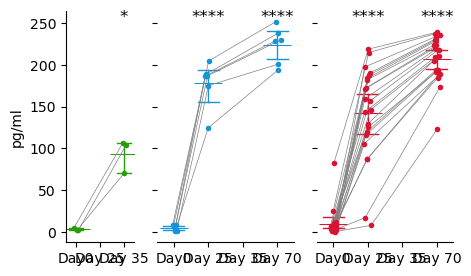

In [14]:
from scipy import stats
from statsmodels.stats import multitest
from matplotlib.ticker import LogLocator, LogFormatter

fig, ax = plt.subplots(1,3,figsize=[5,3], # 6,3.5
                       gridspec_kw={'width_ratios': [3, 6, 6]}
                       ,sharey=True
                      )

gene_name='titer_0.001'

max_y = final[gene_name].max()
min_y = final[gene_name].min()

axes = ax.ravel()
k=0

vaccine_type=['J&J', 'Moderna', 'PFIZER']
for i in vaccine_type:
    dfm_temp = final[final.VACCINE == i]
    dfm_temp = dfm_temp.dropna()
    dfm_baseline = dfm_temp[dfm_temp['Visit'] == 'Day0'].reset_index(drop=True)
    pvalues = dict()
    fdrvalues = dict()
    for x in dfm_temp['Visit'].unique():
        if 'Day 0' not in x:
            try:
                stat, pvalue = test_ttest(
                    dfm_temp[dfm_temp['Visit'] == x][gene_name].astype(float),
                    dfm_baseline[gene_name].astype(float)
                )
                pvalues[x] = pvalue
            except:
                pvalues[x] = 1

    strip = sns.stripplot(x='Visit', y=gene_name, data=dfm_temp, 
              jitter=True, 
              color=color_pallet[k], 
              dodge=True, 
              size=4, 
              legend=False, 
              ax = axes[k]
              )

    sns.pointplot(data=dfm_temp, x="Visit",
            y=gene_name,
            errorbar=("ci", 95),
            capsize=.6, 
            markersize=20,
            # color=".5", 
            color=color_pallet[k], 
            linestyle="none", 
            linewidth=1,
            marker="_", ax=axes[k]
            # ,log_scale=True
            )
    
    combine_off = []
    collections = strip.collections
    for col in collections:
        offsets = col.get_offsets()
        plot_data = pd.DataFrame(offsets, columns=['x', 'y'])
        plot_data = plot_data.sort_values('y')
        combine_off.append(plot_data)
    combine_off = pd.concat(combine_off).reset_index(drop=True)
    combine_off['sub'] = dfm_temp['donor'].values
    
    sns.lineplot(x='x', y='y', data=combine_off, hue='sub', 
                 legend=False, palette=['grey'] * 6, #
                 markers=False, linewidth=0.5, ax = axes[k]
                )
    
    axes[0].set_ylabel("pg/ml") 

    counter = 0
    for idx in dfm_temp['Visit'].unique()[1:]:
        axes[k].text(x=idx, y=max_y+max_y*0.000001, s=convert_pvalue_to_asterisks(pvalues[idx]),
                     color='black', fontsize=12, ha='center') 
        counter += 1
        
    k += 1
    
for ax in axes[1:]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.minorticks_off()
    ax.set_ylabel('') 

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

for ax in axes[0:]:
    ax.set_xlabel('')
    ax.minorticks_off()

In [15]:
data = data.sort_values('VACCINE')

In [16]:
color_pallet=['#299C0C','#1494D9','#D91432']

/tmp/ipykernel_1078550/2630225995.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='AGE (yrs)', y='VACCINE', fill=True,


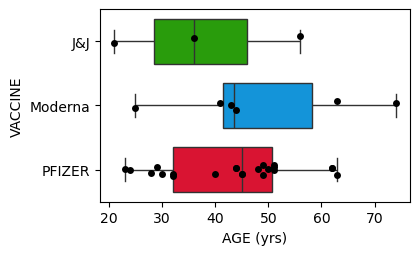

In [17]:
plt.figure(figsize=(4, 2.5))

sns.boxplot(data=data, x='AGE (yrs)', y='VACCINE', fill=True,
         palette=color_pallet,
         saturation=1,   
         showfliers=False, 
         width=0.7
         )

sns.stripplot(x='AGE (yrs)', y='VACCINE', data=data, 
          jitter=True, 
          color='k',
          dodge=True, 
          size=5, 
          legend=False, 
          )


from scipy.stats import kruskal
stat, p_value = kruskal(data['AGE (yrs)'][data['VACCINE'] == 'J&J'], 
                        data['AGE (yrs)'][data['VACCINE'] == 'Moderna'], 
                        data['AGE (yrs)'][data['VACCINE'] == 'PFIZER']
                        )

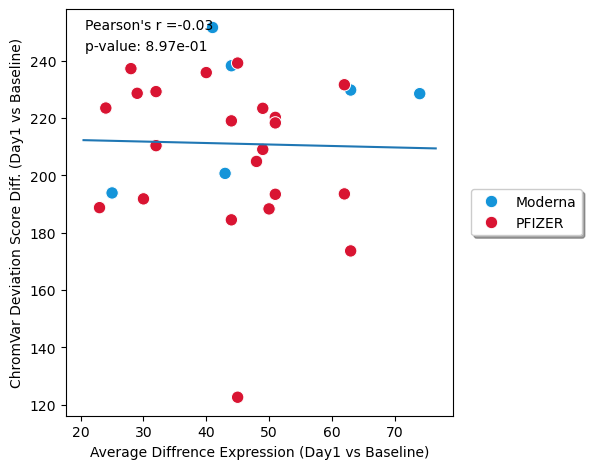

In [21]:
import scipy as sp

final_day70 = final[(final['VACCINE'] != 'J&J') & (final['Visit'] == 'Day 70')]

sns.scatterplot(x='age', y='titer_0.001', data=final_day70, 
             hue='VACCINE', 
             legend=True, 
             palette=color_pallet[1:],
             s=80)
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)

r, p = sp.stats.pearsonr(x=final_day70['age'], y=final_day70['titer_0.001'])
ax = plt.gca()

import numpy as np
m, b = np.polyfit(final_day70['age'], final_day70['titer_0.001'], 1)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')

plt.ylabel('ChromVar Deviation Score Diff. (Day1 vs Baseline)')
plt.xlabel('Average Diffrence Expression (Day1 vs Baseline)')

plt.text(.05, .95, "Pearson's r ={:.2f}".format(r), transform=ax.transAxes)
plt.text(.05, .9, f'p-value: {p:.2e}', transform=ax.transAxes)
plt.tight_layout()
